# **Project Title: Cryptocurrency Volatility Prediction Using XGBoost**

**Language: Python**

**Library Stack: pandas, seaborn, XGBoost, scikit-learn, matplotlib, joblib**

**Install Libraries**

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost

**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


Upload Dataset

In [3]:
from google.colab import files
uploaded = files.upload()


Saving dataset.csv to dataset.csv


**Load & Preview the data**

In [4]:
df = pd.read_csv('dataset.csv')
df.head()


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07


**Clean & Transform**

In [5]:
# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'timestamp'], inplace=True)

# Convert date column
df['date'] = pd.to_datetime(df['date'])

# Sort data
df = df.sort_values(by=['crypto_name', 'date'])

# Handle missing and infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# Volatility: (high - low) / open
df['volatility'] = (df['high'] - df['low']) / df['open']

# Rolling volatility (7 days)
df['volatility_7d'] = df.groupby('crypto_name')['volatility'].transform(lambda x: x.rolling(window=7).mean())

# Liquidity ratio: volume / market cap
df['liquidity_ratio'] = df['volume'] / (df['marketCap'] + 1e-8)

# Bollinger Bands
rolling_mean = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=14).mean())
rolling_std = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=14).std())
df['bb_bandwidth'] = (rolling_mean + 2*rolling_std - (rolling_mean - 2*rolling_std)) / (rolling_mean + 1e-8)

# ATR: avg of (high - low)
df['atr_14'] = df.groupby('crypto_name').apply(lambda group: group['high'] - group['low']).reset_index(drop=True)
df['atr_14'] = df.groupby('crypto_name')['atr_14'].transform(lambda x: x.rolling(window=14).mean())

# Drop rows with NA due to rolling
df.dropna(inplace=True)

# Normalize numerical columns
scaler = MinMaxScaler()
to_scale = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'volatility_7d', 'liquidity_ratio', 'bb_bandwidth', 'atr_14']
df[to_scale] = scaler.fit_transform(df[to_scale])

df.reset_index(drop=True, inplace=True)
df.head()


,open,high,low,close,volume,marketCap,crypto_name,date,volatility,volatility_7d,liquidity_ratio,bb_bandwidth,atr_14
0,0.000761,0.000321,0.000662,0.000651,0.000017,0.000174,Aave,2020-10-15,0.156893,0.053286,2.726537e-19,0.080425,0.000046
1,0.000635,0.000271,0.000589,0.000585,0.000151,0.000286,Aave,2020-10-16,0.111068,0.054135,1.486544e-18,0.027760,0.000043
2,0.000585,0.000266,0.000581,0.000612,0.000123,0.000300,Aave,2020-10-17,0.112540,0.054906,1.163786e-18,0.028375,0.000040
3,0.000613,0.000257,0.000595,0.000603,0.000115,0.000295,Aave,2020-10-18,0.053586,0.054771,1.102477e-18,0.028700,0.000030
4,0.000605,0.000253,0.000541,0.000533,0.000140,0.000261,Aave,2020-10-19,0.123512,0.055370,1.520366e-18,0.030843,0.000026


**Dataset Overview**

In [6]:
# Basic stats
print(df.describe())

# Check number of cryptos
print("Cryptocurrencies available:", df['crypto_name'].unique())


               open          high           low         close        volume  \
count  72230.000000  72230.000000  72230.000000  72230.000000  72230.000000   
mean       0.012998      0.005576      0.012814      0.013011      0.006350   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000003      0.000001      0.000002      0.000003      0.000025   
50%        0.000025      0.000011      0.000024      0.000025      0.000321   
75%        0.000397      0.000173      0.000382      0.000397      0.001941   
max        1.000000      1.000000      1.000000      1.000000      1.000000   
std        0.077820      0.033446      0.076795      0.077858      0.027533   

          marketCap                           date    volatility  \
count  72230.000000                          72230  72230.000000   
mean       0.011679  2019-10-17 07:13:32.105773312      0.085302   
min        0.000000            2013-05-18 00:00:00      0.000000   
25%        0.000

**Upload Cleaned Dataset**

In [7]:
# Upload Cleaned Dataset

from google.colab import files
uploaded = files.upload()


Saving cleaned_dataset.csv to cleaned_dataset.csv


Unique Cryptocurrencies: 56


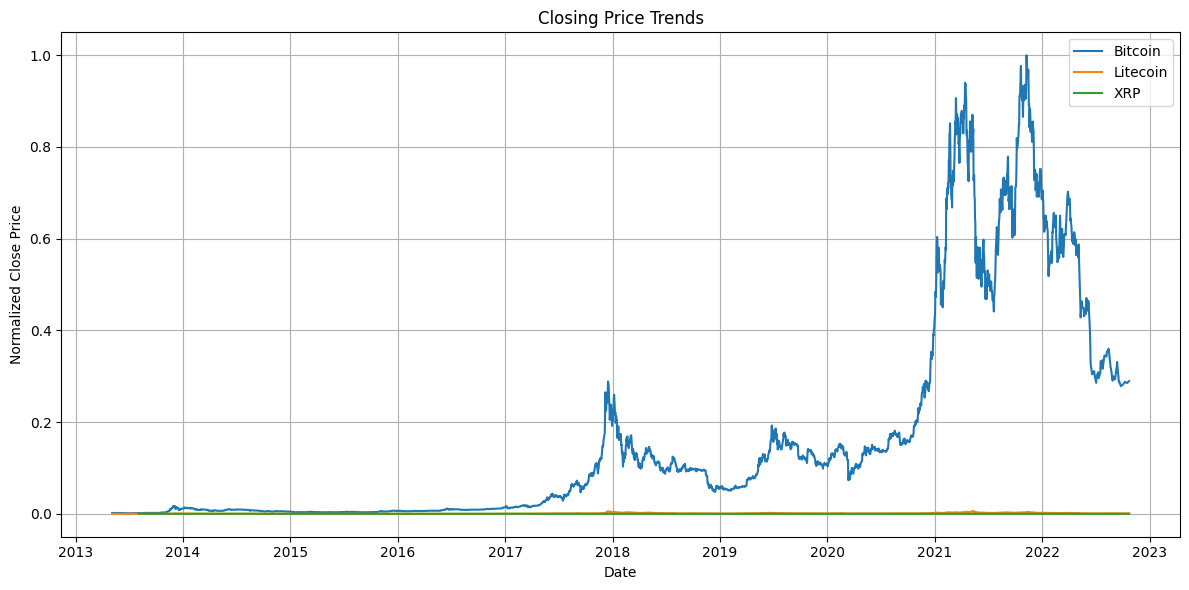

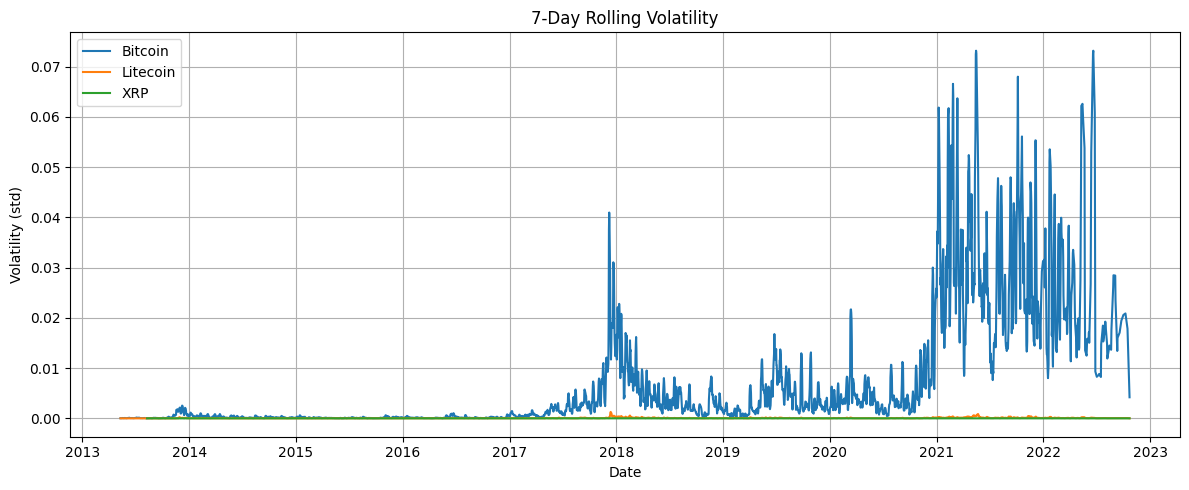

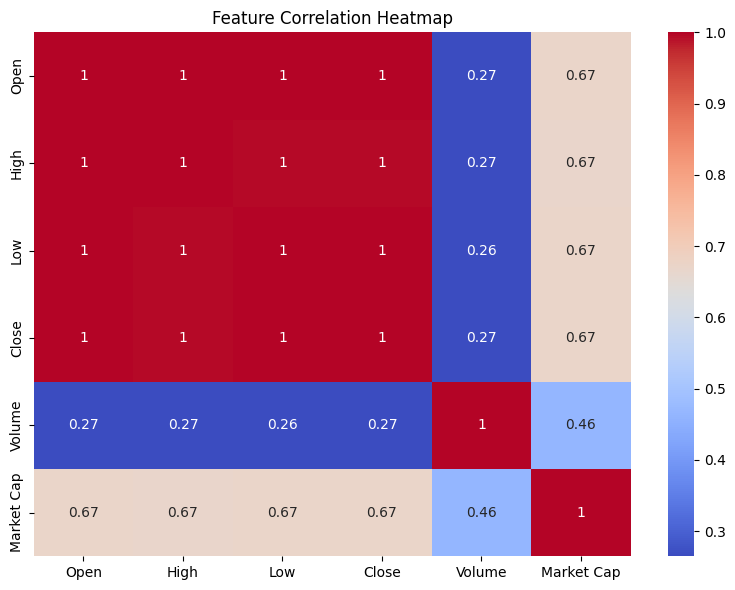

In [8]:

# Load cleaned data
df = pd.read_csv("cleaned_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])

# 1. Number of cryptocurrencies
print("Unique Cryptocurrencies:", df['Symbol'].nunique())

# 2. Plot Closing Price Trends for Top 3 Cryptos
top_cryptos = df['Symbol'].value_counts().head(3).index.tolist()
plt.figure(figsize=(12, 6))
for symbol in top_cryptos:
    subset = df[df['Symbol'] == symbol]
    plt.plot(subset['Date'], subset['Close'], label=symbol)
plt.title("Closing Price Trends")
plt.xlabel("Date")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Volatility (Rolling Std of Close)
plt.figure(figsize=(12, 5))
for symbol in top_cryptos:
    subset = df[df['Symbol'] == symbol].copy()
    subset['Volatility'] = subset['Close'].rolling(window=7).std()
    plt.plot(subset['Date'], subset['Volatility'], label=symbol)
plt.title("7-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (std)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap
numerical_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [9]:
# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort data
df = df.sort_values(by=['Symbol', 'Date'])

# Daily returns
df['Return'] = df.groupby('Symbol')['Close'].pct_change()

# Rolling Volatility (standard deviation of returns)
df['Volatility_7d'] = df.groupby('Symbol')['Return'].rolling(window=7).std().reset_index(0, drop=True)
df['Volatility_14d'] = df.groupby('Symbol')['Return'].rolling(window=14).std().reset_index(0, drop=True)

# Liquidity Ratio
df['Liquidity_Ratio'] = df['Volume'] / df['Market Cap']

# Moving Averages
df['MA_7'] = df.groupby('Symbol')['Close'].rolling(window=7).mean().reset_index(0, drop=True)
df['MA_14'] = df.groupby('Symbol')['Close'].rolling(window=14).mean().reset_index(0, drop=True)

# Price Range (daily volatility indicator)
df['Price_Range'] = (df['High'] - df['Low']) / df['Open']

# Drop rows with NaNs caused by rolling windows
df = df.dropna()

# Preview
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,Market Cap,timestamp,Symbol,Date,Return,Volatility_7d,Volatility_14d,Liquidity_Ratio,MA_7,MA_14,Price_Range
14,45325,0.000635,0.000271,0.000589,0.000585,0.000151,0.000286,2020-10-16T23:59:59.999Z,Aave,2020-10-16,-0.102758,0.074470,27.237170,0.525890,0.000712,0.000707,-0.501248
15,45398,0.000585,0.000266,0.000581,0.000612,0.000123,0.000300,2020-10-17T23:59:59.999Z,Aave,2020-10-17,0.047376,0.074141,0.084916,0.411709,0.000696,0.000695,-0.540102
16,45457,0.000613,0.000257,0.000595,0.000603,0.000115,0.000295,2020-10-18T23:59:59.999Z,Aave,2020-10-18,-0.014988,0.072888,0.084903,0.390020,0.000677,0.000682,-0.550678
17,45502,0.000605,0.000253,0.000541,0.000533,0.000140,0.000261,2020-10-19T23:59:59.999Z,Aave,2020-10-19,-0.116196,0.070810,0.088698,0.537856,0.000643,0.000664,-0.476715
18,45555,0.000534,0.000224,0.000483,0.000476,0.000173,0.000233,2020-10-20T23:59:59.999Z,Aave,2020-10-20,-0.106416,0.072457,0.076554,0.740418,0.000603,0.000653,-0.485564


# **Load feature-engineered DataFrame**

In [10]:

# Features and Target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap',
            'Return', 'Liquidity_Ratio', 'MA_7', 'MA_14', 'Price_Range']
target = 'Volatility_7d'

# Remove NaNs and infinite values
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=features + [target])

# Define your features and target
X = df[features]
y = df['Volatility_7d']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define and train model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 Model Evaluation:")
print(f"✅ MAE:  {mae:.6f}")
print(f"✅ RMSE: {rmse:.6f}")
print(f"✅ R²:   {r2:.4f}")


📊 Model Evaluation:
✅ MAE:  0.020998
✅ RMSE: 0.056805
✅ R²:   0.2182


In [11]:
# import Joblib

import joblib
joblib.dump(model, "xgboost_volatility.pkl")

['xgboost_volatility.pkl']

In [12]:
# Download .pkl File

from google.colab import files
files.download("xgboost_volatility.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Plot Actual vs Predicted.**

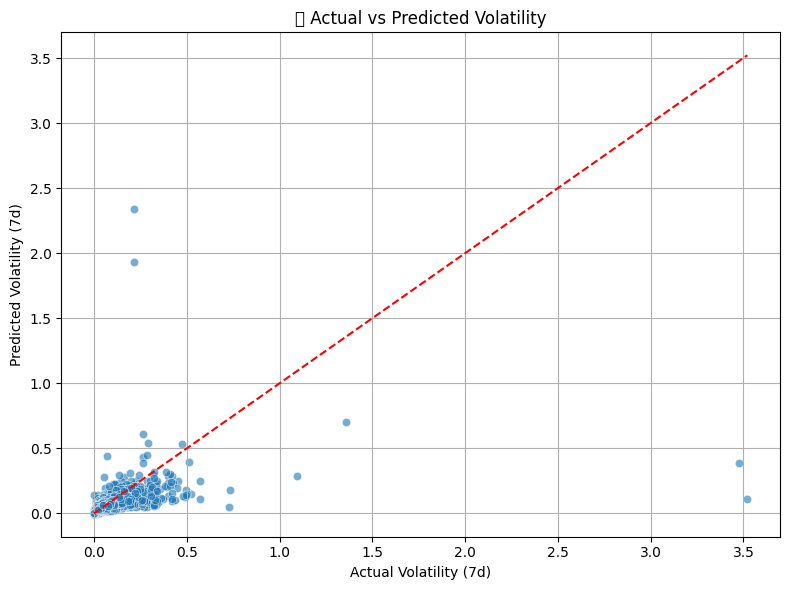

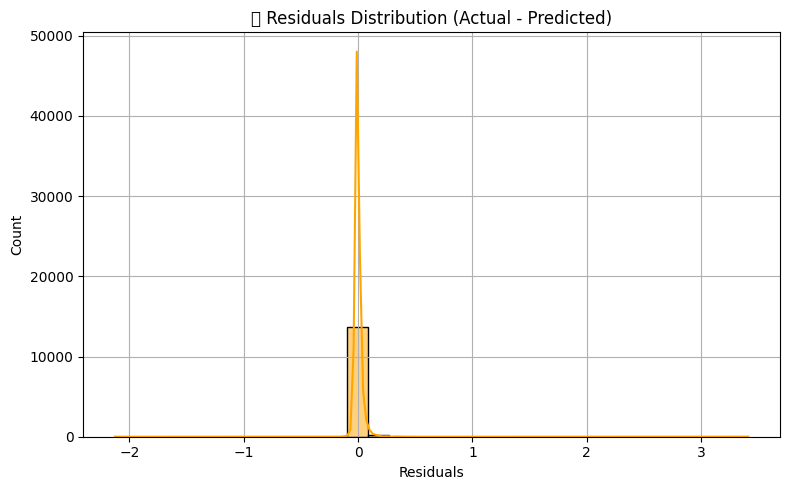

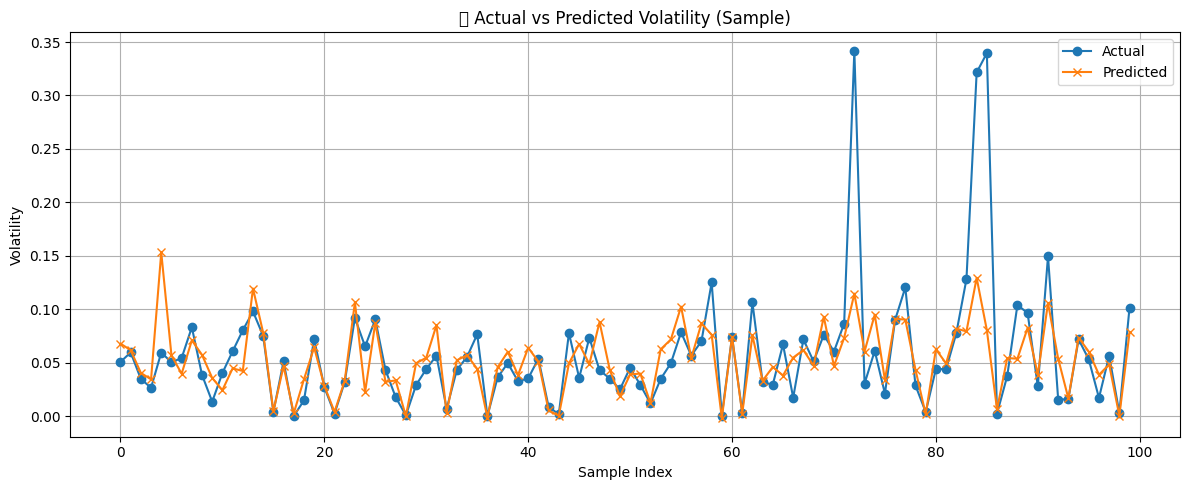

In [13]:
# 1. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree reference line
plt.xlabel("Actual Volatility (7d)")
plt.ylabel("Predicted Volatility (7d)")
plt.title("📈 Actual vs Predicted Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title("📉 Residuals Distribution (Actual - Predicted)")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Line Plot: First 100 Predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title("📊 Actual vs Predicted Volatility (Sample)")
plt.xlabel("Sample Index")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()